# CEBD 1261 Final Project : NYC Taxi trip duration

In this notebook, I Will present build a ML model in Pyspark and predicting the Nyc Taxi Trip Duration.


Name: Reeta Sharma

# Introduction
In this data set, we will build a model to accurately predict the trip duration of New York City(NYC) based on the historical data provided by NYC taxi committee. In many big cities such as New York, London, Tokyo, Hongkong, Shanghai, Beijing has enormous population and complicated transportation system. Public bus and taxi play a very important role in these giant cities. It is critical that city’s administrative system build an efficient managements system for transportation operation and optimization. In this technical article, we present a model that leverage machine learning and data analytical techniques to accurately predict the trip duration of a taxi trip given large volume of historical operation data. 


NYC taxi operation committee releases 1.5 million data samples of one-year operation data ranging from 2016-01-01 to 2016-12-31. Among the whole data set, data of half a year from 2016-01-01 to 2016-06-30 is provided to be training set and the rest data is test set.

# The features in data set is listed below:
    • Id: order id for each taxi trip
    • Vendor_id: operation business firm id
    • Pickup_datetime: timestamp of pickup
      dropoff_datetime :timestamp of dropoff (this one is not useful)
      passenger_count : Count of passengers (this one is also not useful)
    • Pickup_longitude: geolocation of pickup
    • Pickip_lattitude: geolocation of pickup
    • Dropoff_longtitude: geolocation of dropoff
    • Dropoff_lattitude: geolocation of dropoff
    • Store_and_fwd_flag: if the user’s information is recorded in system
    • Trip_duration(in seconds): time elapsed for this trip, this is the target we need to predict

Drop-off timestamp is given in training set but not in test set. It is reasonable because when passenger order a taxi, he/she will not know the drop-off time. Therefore, drop-off timestamp cannot be used to build the predictive system. Pick-up and drop-off geolocation is given because passenger can set pickup and drop-off locations before ordering a taxi. 

It is not enough to build accurate predictive system only based on these basic features. Feature engineering is the next step if one wants a wonderful predictive model. We performed various methods to extend our features. First, we show some visualization of statistical analysis for some useful features.

## 1. Import important libs and some helper functions

Import some libs used in this session and some helper functions

In [1]:
import csv 
import pandas as pd, numpy as np
# spark 
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext as sc
from pyspark.sql import SQLContext
from pyspark.mllib.tree import RandomForest
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import  VectorIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pandas.plotting import register_matplotlib_converters
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

In [2]:
spark = SparkSession.builder.appName("My Project").getOrCreate()


In [3]:
spark

In [4]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=My Project>

In [5]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [6]:
Trip_DATA = '/home/reeta/Desktop/Machine_learning_1260/ML_Pyspark/taxi_trip_duration/train.csv'

In [7]:
# Load Taxi Trip Data
Trip_df = spark.read.csv(path=Trip_DATA, inferSchema=True,header=True)

In [8]:
# Inspect first five rows
Trip_df.take(5)

[Row(id='id2875421', vendor_id=2, pickup_datetime='2016-03-14 17:24:55', dropoff_datetime='2016-03-14 17:32:30', passenger_count=1, pickup_longitude=-73.9821548461914, pickup_latitude=40.76793670654297, dropoff_longitude=-73.96463012695312, dropoff_latitude=40.765602111816406, store_and_fwd_flag='N', trip_duration=455),
 Row(id='id2377394', vendor_id=1, pickup_datetime='2016-06-12 00:43:35', dropoff_datetime='2016-06-12 00:54:38', passenger_count=1, pickup_longitude=-73.98041534423828, pickup_latitude=40.738563537597656, dropoff_longitude=-73.99948120117188, dropoff_latitude=40.73115158081055, store_and_fwd_flag='N', trip_duration=663),
 Row(id='id3858529', vendor_id=2, pickup_datetime='2016-01-19 11:35:24', dropoff_datetime='2016-01-19 12:10:48', passenger_count=1, pickup_longitude=-73.9790267944336, pickup_latitude=40.763938903808594, dropoff_longitude=-74.00533294677734, dropoff_latitude=40.710086822509766, store_and_fwd_flag='N', trip_duration=2124),
 Row(id='id3504673', vendor_id=

In [9]:
# Show first five rows
Trip_df.show(5)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:10:48|    

In [10]:
# show the dataframe columns
Trip_df.columns

['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration']

In [11]:
# Just to be sure, let us inspect the schema. It should match exactly the specified one.
# show the schema of the dataframe
Trip_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



# Data Exploration

In [12]:
# run a sample selection
Trip_df.select('pickup_latitude','dropoff_latitude').show(10)

+------------------+------------------+
|   pickup_latitude|  dropoff_latitude|
+------------------+------------------+
| 40.76793670654297|40.765602111816406|
|40.738563537597656| 40.73115158081055|
|40.763938903808594|40.710086822509766|
|   40.719970703125| 40.70671844482422|
|40.793209075927734| 40.78252029418945|
| 40.74219512939453|40.749183654785156|
| 40.75783920288086| 40.76589584350586|
| 40.79777908325195| 40.76055908203125|
|40.738399505615234| 40.73281478881836|
| 40.74433898925781| 40.78998947143555|
+------------------+------------------+
only showing top 10 rows



In [13]:
# group by Trip Duration and see the distribution
result_df = Trip_df.groupBy("trip_duration").count().sort("trip_duration", ascending=False)

In [14]:
result_df.show(20)

+-------------+-----+
|trip_duration|count|
+-------------+-----+
|      3526282|    1|
|      2227612|    1|
|      2049578|    1|
|      1939736|    1|
|        86392|    1|
|        86391|    1|
|        86390|    1|
|        86387|    1|
|        86385|    1|
|        86379|    1|
|        86378|    2|
|        86377|    2|
|        86369|    4|
|        86367|    2|
|        86366|    1|
|        86365|    1|
|        86364|    2|
|        86363|    1|
|        86362|    4|
|        86361|    3|
+-------------+-----+
only showing top 20 rows



<AxesSubplot:xlabel='trip_duration'>

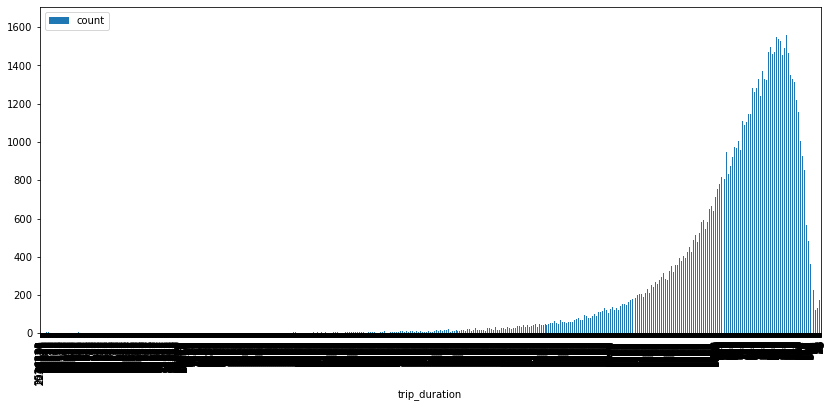

In [15]:
result_df.toPandas().plot.bar(x='trip_duration',figsize=(14, 6))

In [15]:
# group by passenger_count and see the distribution
pass_df = Trip_df.groupBy("passenger_count").count().sort("passenger_count", ascending=True)

In [16]:
pass_df.show(20) 

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              0|     60|
|              1|1033540|
|              2| 210318|
|              3|  59896|
|              4|  28404|
|              5|  78088|
|              6|  48333|
|              7|      3|
|              8|      1|
|              9|      1|
+---------------+-------+



<AxesSubplot:xlabel='passenger_count'>

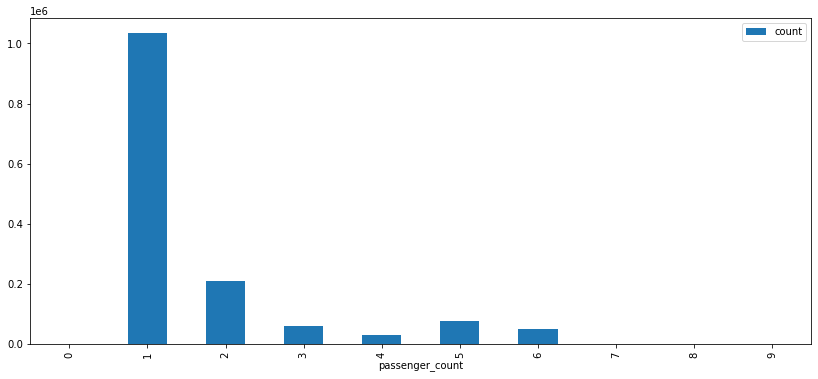

In [18]:
pass_df.toPandas().plot.bar(x='passenger_count',figsize=(14, 6))

In [17]:
Store_df = Trip_df.groupBy("store_and_fwd_flag").count().sort("store_and_fwd_flag", ascending=True)
Store_df.show(10)

+------------------+-------+
|store_and_fwd_flag|  count|
+------------------+-------+
|                 N|1450599|
|                 Y|   8045|
+------------------+-------+



In [18]:
# Seperate date from Pickup datetime  
from pyspark.sql.functions import *
Trip_df.select( date_format(col("dropoff_datetime"),"yyyy-MM-dd").alias('ts').cast("date")).show(10,False)


+----------+
|ts        |
+----------+
|2016-03-14|
|2016-06-12|
|2016-01-19|
|2016-04-06|
|2016-03-26|
|2016-01-30|
|2016-06-17|
|2016-05-21|
|2016-05-27|
|2016-03-10|
+----------+
only showing top 10 rows



In [19]:
# Seperate date from Pickup datetime
from pyspark.sql.functions import *
Trip_df.select( date_format(col("pickup_datetime"),"yyyy-MM-dd").alias('ts').cast("Date")).show(10,False)


+----------+
|ts        |
+----------+
|2016-03-14|
|2016-06-12|
|2016-01-19|
|2016-04-06|
|2016-03-26|
|2016-01-30|
|2016-06-17|
|2016-05-21|
|2016-05-27|
|2016-03-10|
+----------+
only showing top 10 rows



In [20]:
from pyspark.sql.functions import hour,minute,second,to_date
Trip_df = Trip_df.withColumn('dropoff_hour',hour(Trip_df.dropoff_datetime))
Trip_df = Trip_df.withColumn('pickup_hour',hour(Trip_df.pickup_datetime))
Trip_df = Trip_df.withColumn('dropoff_min',minute(Trip_df.dropoff_datetime))
Trip_df = Trip_df.withColumn('pickup_min',minute(Trip_df.dropoff_datetime))
Trip_df = Trip_df.withColumn('date',to_date(Trip_df.dropoff_datetime))
Trip_df = Trip_df.withColumn("pickup_dayofweek", dayofweek(Trip_df["pickup_datetime"])) 
Trip_df = Trip_df.withColumn("pickup_week", weekofyear(Trip_df["pickup_datetime"])) 
Trip_df.show()

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+------------+-----------+-----------+----------+----------+----------------+-----------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|dropoff_hour|pickup_hour|dropoff_min|pickup_min|      date|pickup_dayofweek|pickup_week|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+------------+-----------+-----------+----------+----------+----------------+-----------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|   

# Simple Geo Visualisation
In order to get an understanding of the data, let us first make a geo visualization using some Python functionality. We'd eventually want to draw the pickup locations on top of a map, so we understand the whole area that is served by the taxi cabs. We might want to use this information later when it comes to the ML part.




In [21]:
quantile = Trip_df \
    .filter((Trip_df["pickup_longitude"] > -75) & (Trip_df["pickup_longitude"] < -65)) \
    .filter((Trip_df["pickup_latitude"] > 35) & (Trip_df["pickup_latitude"] < 45)) \
    .stat.approxQuantile(["pickup_longitude", "pickup_latitude"], [0.025,0.975], 0.01)

min_pickup_longitude = quantile[0][0]
max_pickup_longitude = quantile[0][1]
min_pickup_latitude = quantile[1][0]
max_pickup_latitude = quantile[1][1]

print("min_pickup_longitude=" + str(min_pickup_longitude))
print("max_pickup_longitude=" + str(max_pickup_longitude))
print("min_pickup_latitude=" + str(min_pickup_latitude))
print("max_pickup_latitude=" + str(max_pickup_latitude))

min_pickup_longitude=-74.01109313964844
max_pickup_longitude=-73.86348724365234
min_pickup_latitude=40.64704513549805
max_pickup_latitude=40.79458236694336


In [22]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Visualize the pickup location
Now by using some appropriate Python libraries, we can visualize the pickup locations nicely on a map.

Since the data contains some bogus coordinates and some (maybe correct) outliers, we limit the area to the extends that we estimated above. This means that we throw away all records which lie outside of the core area (only for this visualization, of course!)

/home/reeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/reeta/anaconda3/lib/python3.7/site-packages/contextily/tile.py:268: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,


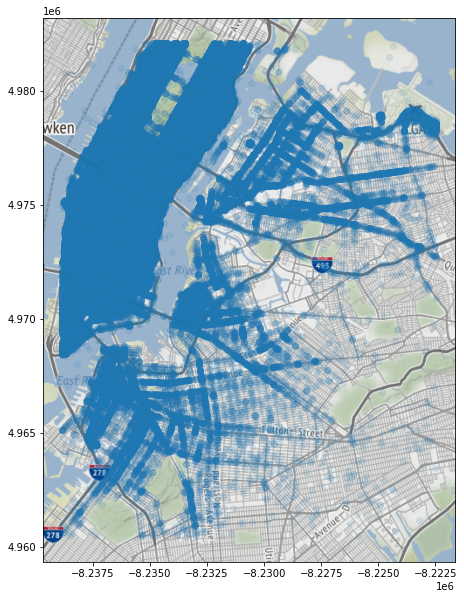

In [25]:
df = Trip_df.select("pickup_longitude","pickup_latitude") \
    .filter((Trip_df["pickup_longitude"] >= min_pickup_longitude) & (Trip_df["pickup_longitude"] <= max_pickup_longitude)) \
    .filter((Trip_df["pickup_latitude"] >= min_pickup_latitude) & (Trip_df["pickup_latitude"] <= max_pickup_latitude)) \
    .toPandas()

# Convert DataFrame to GeoDataFrame  
coords = pd.Series(zip(df["pickup_longitude"], df["pickup_latitude"]))
geo_df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = coords.apply(Point)).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(figsize=(15, 10), alpha=0.1)

# Add basemap below
add_basemap(ax, 12)

In [23]:
min_pickup_longitude=-74.007698
max_pickup_longitude=-73.776711
min_pickup_latitude=40.706902
max_pickup_latitude=40.799072

longitude_grid_size = 10
latitude_grid_size = 5
longitude_grid_diff = (max_pickup_longitude - min_pickup_longitude) / longitude_grid_size
latitude_grid_diff = (max_pickup_latitude - min_pickup_latitude) / latitude_grid_size

In [24]:
from pyspark.sql.functions import *
import pyspark.sql.functions as f
Trip_df = Trip_df \
    .withColumn("lat_idx", f.rint((Trip_df["pickup_latitude"] - min_pickup_latitude)/latitude_grid_diff)) \
    .withColumn("long_idx", f.rint((Trip_df["pickup_longitude"] - min_pickup_longitude)/longitude_grid_diff)) \
    .withColumn("lat_idx", f.when((f.col("lat_idx") >= 0) & (f.col("lat_idx") < latitude_grid_size), f.col("lat_idx")).otherwise(-1).cast("int")) \
    .withColumn("long_idx", f.when((f.col("long_idx") >= 0) & (f.col("long_idx") < longitude_grid_size), f.col("long_idx")).otherwise(-1).cast("int")) \

Trip_df.limit(10).toPandas()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dropoff_hour,pickup_hour,dropoff_min,pickup_min,date,pickup_dayofweek,pickup_week,lat_idx,long_idx
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,17,32,32,2016-03-14,2,11,3,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,0,54,54,2016-06-12,1,23,2,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,12,11,10,10,2016-01-19,3,3,3,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,19,39,39,2016-04-06,4,14,1,-1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,13,38,38,2016-03-26,7,12,-1,1
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,22,22,9,9,2016-01-30,7,4,2,1
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,22,22,40,40,2016-06-17,6,24,3,2
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,8,7,20,20,2016-05-21,7,20,-1,2
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,23,23,16,16,2016-05-27,6,21,2,0
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225,22,21,5,5,2016-03-10,5,10,2,1


Text(0.5, 1.0, 'Day of week')

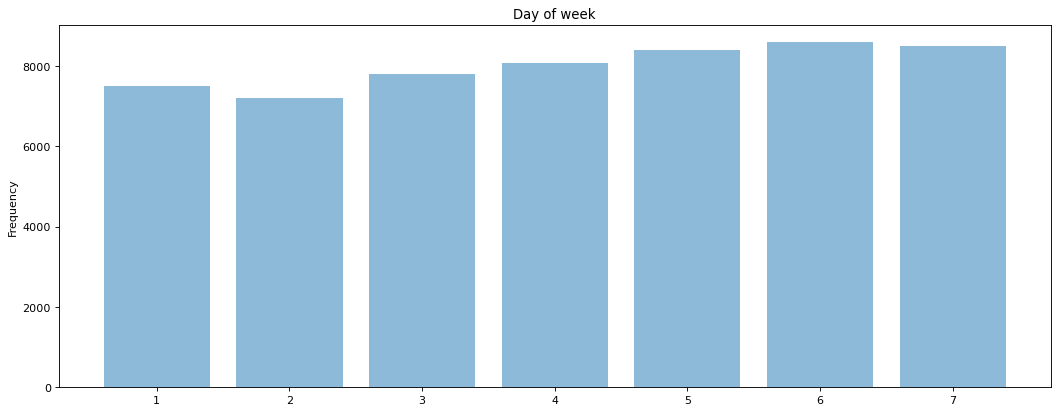

In [25]:
Trip_df1 = Trip_df.groupBy("pickup_dayofweek", "pickup_week").count().groupBy("pickup_dayofweek") .agg(f.avg("count").alias("avg_count"))
pdf = Trip_df1.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(pdf["pickup_dayofweek"], pdf["avg_count"], align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.title('Day of week')

In [26]:
Trip_df1.show()

+----------------+-----------------+
|pickup_dayofweek|        avg_count|
+----------------+-----------------+
|               1|7514.076923076923|
|               6|8597.423076923076|
|               3|7798.038461538462|
|               5|8406.692307692309|
|               4|8082.153846153846|
|               7|8494.923076923076|
|               2|7208.384615384615|
+----------------+-----------------+



In [27]:
import datetime
from pyspark.sql.functions import *
Trip_df.select(
    year("pickup_datetime").alias('year'), 
    month("pickup_datetime").alias('month'), 
    dayofmonth("pickup_datetime").alias('day')
    
).show()

+----+-----+---+
|year|month|day|
+----+-----+---+
|2016|    3| 14|
|2016|    6| 12|
|2016|    1| 19|
|2016|    4|  6|
|2016|    3| 26|
|2016|    1| 30|
|2016|    6| 17|
|2016|    5| 21|
|2016|    5| 27|
|2016|    3| 10|
|2016|    5| 10|
|2016|    5| 15|
|2016|    2| 19|
|2016|    6|  1|
|2016|    5| 27|
|2016|    5| 16|
|2016|    4| 11|
|2016|    4| 14|
|2016|    6| 27|
|2016|    6|  5|
+----+-----+---+
only showing top 20 rows



In [28]:
import datetime
from pyspark.sql.functions import *
Trip_df.select(
    year("dropoff_datetime").alias('year'), 
    month("dropoff_datetime").alias('month'), 
    dayofmonth("dropoff_datetime").alias('day')
    
).show()

+----+-----+---+
|year|month|day|
+----+-----+---+
|2016|    3| 14|
|2016|    6| 12|
|2016|    1| 19|
|2016|    4|  6|
|2016|    3| 26|
|2016|    1| 30|
|2016|    6| 17|
|2016|    5| 21|
|2016|    5| 27|
|2016|    3| 10|
|2016|    5| 10|
|2016|    5| 15|
|2016|    2| 19|
|2016|    6|  1|
|2016|    5| 27|
|2016|    5| 16|
|2016|    4| 11|
|2016|    4| 14|
|2016|    6| 27|
|2016|    6|  5|
+----+-----+---+
only showing top 20 rows



In [29]:

Trip_df = Trip_df.withColumn("trip_duration", col("trip_duration")*60)

In [30]:
Trip_df.show(2)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+------------+-----------+-----------+----------+----------+----------------+-----------+-------+--------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|dropoff_hour|pickup_hour|dropoff_min|pickup_min|      date|pickup_dayofweek|pickup_week|lat_idx|long_idx|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+------------+-----------+-----------+----------+----------+----------------+-----------+-------+--------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463

# Data Preprocessing

In [31]:

    ## Converting to appropriate datatypes
Trip_df = Trip_df.withColumn('pickup_longitude', Trip_df['pickup_longitude'].cast('float'))
Trip_df = Trip_df.withColumn('pickup_latitude', Trip_df['pickup_latitude'].cast('float'))
Trip_df = Trip_df.withColumn('dropoff_longitude', Trip_df['dropoff_longitude'].cast('float'))
Trip_df = Trip_df.withColumn('dropoff_latitude', Trip_df['dropoff_latitude'].cast('float'))
    # removing Outliers ( Checked the distribution of the distance -- Removing distance greater than 20 miles)
Trip_df.show()

+---------+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+------------+-----------+-----------+----------+----------+----------------+-----------+-------+--------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|dropoff_hour|pickup_hour|dropoff_min|pickup_min|      date|pickup_dayofweek|pickup_week|lat_idx|long_idx|
+---------+---------+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+------------+-----------+-----------+----------+----------+----------------+-----------+-------+--------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|   

# Random Forest Regression for predict the target trip duration

In [32]:
Trip_df.registerTempTable("df_train_table")
sqlContext.sql("""
                SELECT id, count(*) 
                FROM df_train_table
                group by 1 
                order by 2 desc 
                limit 10""").show()

+---------+--------+
|       id|count(1)|
+---------+--------+
|id0515898|       1|
|id2677357|       1|
|id0556588|       1|
|id1381256|       1|
|id3524926|       1|
|id0082224|       1|
|id1631034|       1|
|id3829159|       1|
|id3048673|       1|
|id0045059|       1|
+---------+--------+



In [33]:
spark.sql("SELECT count(*) from df_train_table" ).show()

+--------+
|count(1)|
+--------+
| 1458644|
+--------+



In [34]:
Trip_df.registerTempTable("temp_sql_table")
spark_sql_output=sqlContext.sql("""SELECT 
                        dropoff_longitude,
                        dropoff_latitude,
                        pickup_longitude,
                        pickup_latitude, 
                        pickup_dayofweek
                        
                        FROM temp_sql_table """)
print (spark_sql_output.take(10))

[Row(dropoff_longitude=-73.96463012695312, dropoff_latitude=40.765602111816406, pickup_longitude=-73.9821548461914, pickup_latitude=40.76793670654297, pickup_dayofweek=2), Row(dropoff_longitude=-73.99948120117188, dropoff_latitude=40.73115158081055, pickup_longitude=-73.98041534423828, pickup_latitude=40.738563537597656, pickup_dayofweek=1), Row(dropoff_longitude=-74.00533294677734, dropoff_latitude=40.710086822509766, pickup_longitude=-73.9790267944336, pickup_latitude=40.763938903808594, pickup_dayofweek=3), Row(dropoff_longitude=-74.01226806640625, dropoff_latitude=40.70671844482422, pickup_longitude=-74.01004028320312, pickup_latitude=40.719970703125, pickup_dayofweek=4), Row(dropoff_longitude=-73.9729232788086, dropoff_latitude=40.78252029418945, pickup_longitude=-73.97305297851562, pickup_latitude=40.793209075927734, pickup_dayofweek=7), Row(dropoff_longitude=-73.99208068847656, dropoff_latitude=40.749183654785156, pickup_longitude=-73.98285675048828, pickup_latitude=40.742195129

# Training a model

In [35]:
trainingData=spark_sql_output.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["features", "label"])
trainingData.show()
    

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-73.964630126953...|    2|
|[-73.999481201171...|    1|
|[-74.005332946777...|    3|
|[-74.012268066406...|    4|
|[-73.972923278808...|    7|
|[-73.992080688476...|    7|
|[-73.957405090332...|    6|
|[-73.922470092773...|    7|
|[-73.985786437988...|    6|
|[-73.972999572753...|    5|
|[-74.002227783203...|    3|
|[-73.95654296875,...|    1|
|[-73.984405517578...|    6|
|[-73.966110229492...|    4|
|[-73.974655151367...|    6|
|[-73.948760986328...|    2|
|[-73.999290466308...|    2|
|[-73.999656677246...|    5|
|[-73.979194641113...|    2|
|[-73.991203308105...|    1|
+--------------------+-----+
only showing top 20 rows



# Features:
As a first step we need to create so called features from the training data set. Most PySpark ML algorithms expect two specific input columns: A so called label column containing the true value and a so called features column containing a vector of all variables used for prediction.

The label column has to be a simple numeric value, in our case it will be the trip Duration. The features column needs to contain the special data type vector, which is constructed from various attributes of our observations. Some of these attributes can be taken directly from our training data set, while other columns also need to be derived from the original values.

In [36]:
featureIndexer =\
VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(trainingData)

(trainingData, testData) = trainingData.randomSplit([0.7, 0.3])
    # Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="indexedFeatures")
# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)


In [37]:
# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(30)


+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|  4.17185546939824|    7|[-77.896018981933...|
|  4.17185546939824|    3|[-77.039436340332...|
| 4.069772390882633|    4|[-74.711326599121...|
| 4.069772390882633|    7|[-74.647537231445...|
|3.7176707372487385|    6|[-74.602432250976...|
| 4.110282830103872|    6|[-74.406455993652...|
| 4.082821426962443|    7|[-74.405418395996...|
| 4.082821426962443|    3|[-74.399063110351...|
|  4.17185546939824|    3|[-74.398643493652...|
| 4.082821426962443|    2|[-74.398513793945...|
|  4.17185546939824|    7|[-74.350021362304...|
|  4.17185546939824|    7|[-74.317344665527...|
| 4.163253976445385|    2|[-74.290626525878...|
|3.6871268687852314|    6|[-74.286865234375...|
|  4.16298159963492|    7|[-74.253791809082...|
| 4.068503958263031|    5|[-74.246803283691...|
| 4.082821426962443|    2|[-74.246246337890...|
|3.9140431559315174|    1|[-74.242607116

In [38]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
labelCol="label", predictionCol="prediction", metricName="rmse")
print ('='*100)
print ('*** OUTCOME :')
rmse = evaluator.evaluate(predictions)
print(" *** Root Mean Squared Error (RMSE) on test data = %g" % rmse)
rfModel = model.stages[1]
print(' *** : RF MODEL SUMMARY : ', rfModel)  # summary only
print ('='*100)


*** OUTCOME :
 *** Root Mean Squared Error (RMSE) on test data = 1.99212
 *** : RF MODEL SUMMARY :  RandomForestRegressionModel: uid=RandomForestRegressor_8e39f344da13, numTrees=20, numFeatures=4


# linear regression 

In [39]:
x_new =Trip_df

In [41]:
(train_data,test_data) = x_new.randomSplit([0.7,0.3])
print(train_data.count())
print(test_data.count())

1021179
437465


In [36]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
label='trip_duration'
features=['dropoff_longitude','dropoff_latitude','pickup_longitude','pickup_latitude','dropoff_hour','pickup_dayofweek']
#print(features)
assembler = VectorAssembler(inputCols=features,outputCol="features")
train_data_transformed = assembler.transform(train_data)

linearRegressor = LinearRegression(labelCol="trip_duration", featuresCol="features", maxIter=10)
linearModel = linearRegressor.fit(train_data_transformed)

test_data_transformed = assembler.transform(test_data)
prediction = linearModel.transform(test_data_transformed)
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='trip_duration')
rmse = evaluator.evaluate(prediction, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(prediction, {evaluator.metricName: "r2"})
print("RMSE : ", rmse)
print("R2 : ", r2)

RMSE :  423760.0563347816
R2 :  0.0007673688211791152
